In [1]:
'''
folder = str("../logs/20200829_11_53_21/") # 1D no Noise yesPeriodic no Rot - d.keepData(0,91500)
folder = str("../logs/20200829_12_05_54/") # 1D yesNoise yesPeriodic no Rot
folder = str("../logs/20200829_12_14_39/") # 1D no Noise no Periodic no Rot
folder = str("../logs/20200829_12_22_54/") # 1D yesNoise no Periodic no Rot
folder = str("../logs/20200829_12_37_57/") # 1D no Noise yesPeriodic yesRot
folder = str("../logs/20200829_12_50_33/") # 1D yesNoise yesPeriodic yesRot
folder = str("../logs/20200829_12_58_43/") # 1D no Noise no Periodic yesRot
folder = str("../logs/20200829_13_07_41/") # 1D yesNoise no Periodic yesRot
folder = str("../logs/20200829_15_02_13/") # 2D no Noise yesPeriodic no Rot
folder = str("../logs/20200829_15_14_20/") # 2D yesNoise yesPeriodic no Rot
folder = str("../logs/20200829_15_24_14/") # 2D no Noise no Periodic no Rot
folder = str("../logs/20200829_15_35_38/") # 2D yesNoise no Periodic no Rot
folder = str("../logs/20200829_16_11_21/") # 2D no Noise yesPeriodic yesRot
folder = str("../logs/20200829_16_25_41/") # 2D yesNoise yesPeriodic yesRot
folder = str("../logs/20200829_16_39_47/") # 2D yesNoise no Periodic yesRot
folder = str("../logs/20200829_16_48_48/") # 2D no Noise no Periodic yesRot



folder = str("../logs/20201002_10_16_28/") # Y up Stand still 
folder = str("../logs/20201002_10_17_42/") # Y up Calib for Magneto
folder = str("../logs/20201002_10_19_33/") # Y up Test
folder = str("../logs/20201002_11_03_27/") # Z up Stand still
folder = str("../logs/20201002_11_03_37/") # Z up Calib for Magneto
folder = str("../logs/20201002_11_04_35/") # Z up Test
folder = str("../logs/20201002_11_05_25/") # Z up Training 
folder = str("../logs/20201002_11_07_24/") # Y up Training
''';

In [2]:
# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from DataStreamPreprocessor import DataStream, Normalizer, Batcher
from Quaternion_functions import w_flip, w_back_flip, MOC_to_MAD, MAD_to_MOC, transform, turn, distance_check, mocap_correction
import matplotlib.pyplot
import tensorflow as tf
import time
from pyquaternion import Quaternion

tf.random.set_seed(42) 
np.random.seed(42)

from ahrs.utils import WMM
from ahrs.utils import WGS
import ahrs

In [3]:
#folder = str("../logs/20201002_10_16_28/") # Y up - Stand still
folder_calib = str("../logs/20201002_10_17_42/")  # Y up - Calib for Magneto
folder_test  = str("../logs/20201002_10_19_33/")  # Y up - General Test
#folder_test = str("../logs/20201002_10_17_42/") # Y up Calib for Magneto
#file = str("../logs/20201002_11_07_24/") # Y up - Training data

d = DataStream(folder_test)
c = DataStream(folder_calib)

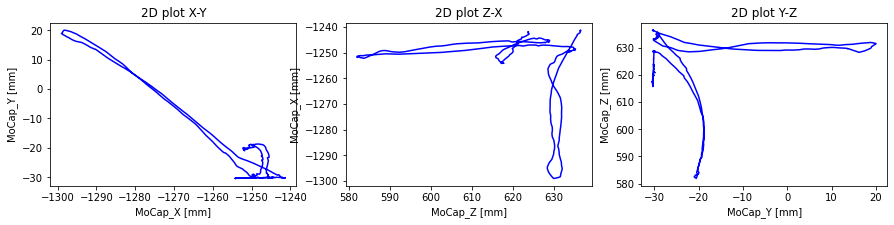

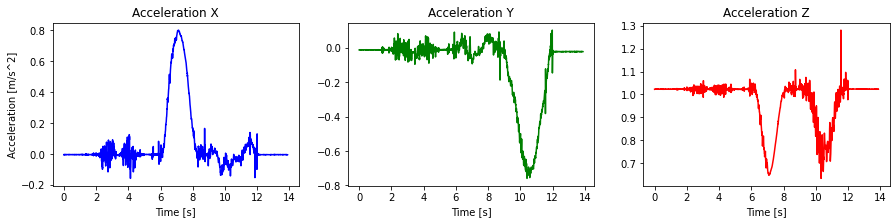

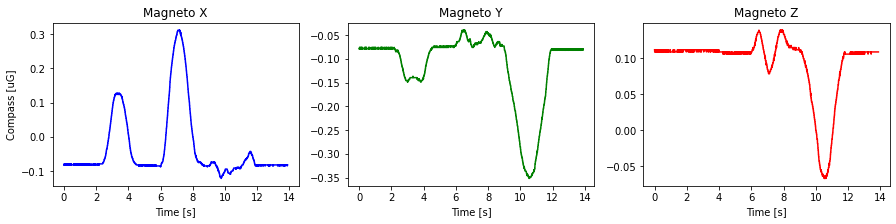

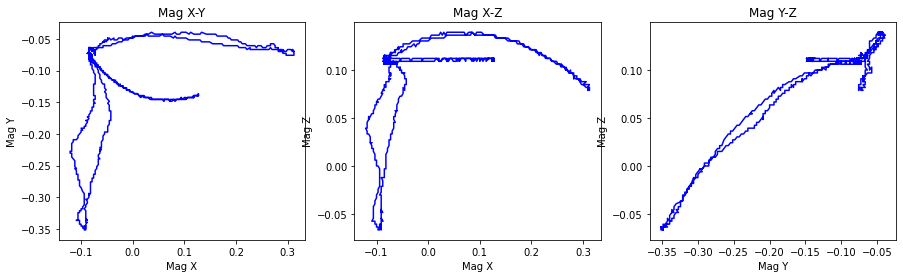

In [4]:
d.plotData(plot3D=True, plot2D=True, acc=True, gyro=True, mag=True, magCalib=True)

In [5]:
d.calibrateMag(c)
print('Magneto offset calibration parameters:' +str(d.mag_offset))

Magneto offset calibration parameters:[ 0.080295  0.065145 -0.25755 ]


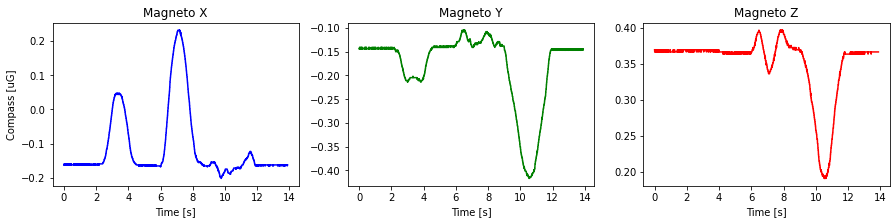

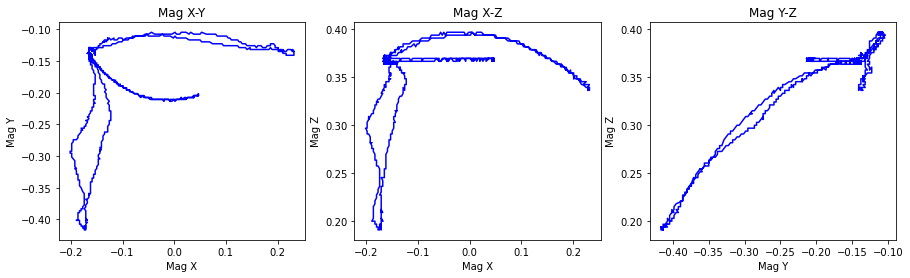

In [6]:
d.plotData(mag=True, magCalib=True)

In [7]:
print('d.data shape: ' + str(d.data.shape))
d.showHeader()

d.data shape: (3471, 20)
0 - Timestamp
1 - AccX
2 - AccY
3 - AccZ
4 - GyroX
5 - GyroY
6 - GyroZ
7 - MagX
8 - MagY
9 - MagZ
10 - MARG_posX
11 - MARG_posY
12 - MARG_posZ
13 - MARG_quatX
14 - MARG_quatY
15 - MARG_quatZ
16 - MARG_quatW
17 - MARG_rotX
18 - MARG_rotY
19 - MARG_rotZ


In [8]:
d.filterData(31, 'hanning', [1, 2, 3]) # filter Acc
d.filterData(31, 'hanning', [4, 5, 6]) # filter Gyro
d.filterData(31, 'hanning', [7, 8, 9]) # filter Mag
d.plotData(acc=True,gyro=True,mag=True)

In [9]:
Acc    = d.data[:,1:4]
Gyro   = d.data[:,4:7]
Mag    = d.data[:,7:10]
MocapQ = d.data[:,13:17]
MocapE = d.data[:,17:20]

print('Acc shape:     ' + str(Acc.shape))
print('Gyro shape:    ' + str(Gyro.shape))
print('Mag shape:     ' + str(Mag.shape))
print('MocapQ shape:  ' + str(MocapQ.shape))
print('MocapE shape:  ' + str(MocapE.shape))

Acc shape:     (3471, 3)
Gyro shape:    (3471, 3)
Mag shape:     (3471, 3)
MocapQ shape:  (3471, 4)
MocapE shape:  (3471, 3)


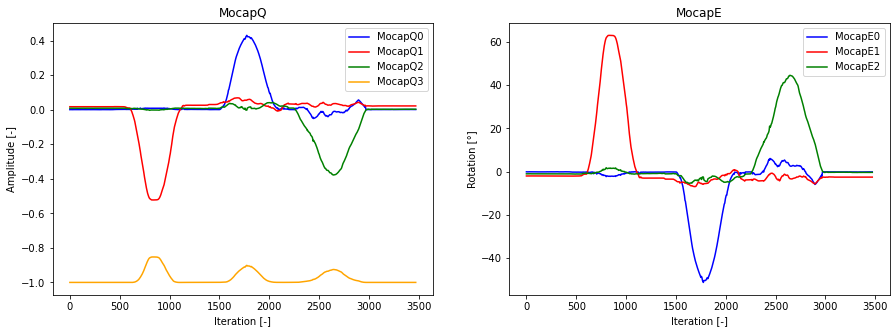

In [10]:
plt.figure(1, figsize=(15, 5))

plt.subplot(121)
plt.title("MocapQ")
plt.plot(MocapQ[:,0], color='blue', label='MocapQ0')
plt.plot(MocapQ[:,1], color='red', label='MocapQ1')
plt.plot(MocapQ[:,2], color='green', label='MocapQ2')
plt.plot(MocapQ[:,3], color='orange', label='MocapQ3')
plt.xlabel('Iteration [-]')
plt.ylabel('Amplitude [-]')
plt.legend()

plt.subplot(122)
plt.title("MocapE")
plt.plot(MocapE[:,0], color='blue', label='MocapE0')
plt.plot(MocapE[:,1], color='red', label='MocapE1')
plt.plot(MocapE[:,2], color='green', label='MocapE2')
plt.xlabel('Iteration [-]')
plt.ylabel('Rotation [°]')
plt.legend()
plt.show()

In [11]:
wmm = WMM(latitude=47.0, longitude=19.0, height=111)
print(wmm.magnetic_elements)

wgs = WGS()      # Creates an ellipsoid model, using Earth's characteristics by default
wgs.normal_gravity(47.0, 111.0)

{'X': 20492.752520449125, 'Y': 1753.3345452191168, 'Z': 41461.435078814844, 'H': 20567.62231984613, 'F': 46282.58513400705, 'I': 63.61553810357098, 'D': 4.8902465010004, 'GV': 4.8902465010004}


9.807664338802024

# MADGWICK

In [12]:
#q_init = [0.0, 0.0, 1.0, 0.0] 
# defining the madgwick vector

MadgwickQ = ahrs.filters.Madgwick(acc=Acc*9.8077, gyr=Gyro/57.3, mag=Mag*10, gain=0.000001, Dt=0.004) #q0=q_init #az itteni beszorzások nekem segítettek az eredményekkel
print('MadgwickQ shape: ' + str(MadgwickQ.Q.shape))                        #gain = 0.000001

plt.figure(3, figsize=(15, 5))
plt.subplot(121)
plt.title("Madgwick")
plt.plot(MadgwickQ.Q[:,0], color='blue', label='Madgwic0')
plt.plot(MadgwickQ.Q[:,1], color='red', label='Madgwic1')
plt.plot(MadgwickQ.Q[:,2], color='green', label='Madgwic2')
plt.plot(MadgwickQ.Q[:,3], color='orange', label='Madgwic3')
plt.xlabel('Iteration [-]')
plt.ylabel('Amplitude [-]')
plt.legend()

plt.subplot(122)
plt.title("MocapQ")
plt.plot(MocapQ[:,0], color='blue', label='MocapQ0')
plt.plot(MocapQ[:,1], color='red', label='MocapQ1')
plt.plot(MocapQ[:,2], color='green', label='MocapQ2')
plt.plot(MocapQ[:,3], color='orange', label='MocapQ3')
plt.xlabel('Iteration [-]')
plt.ylabel('Amplitude [-]')
plt.legend()
plt.show()

plt.show()

MadgwickQ shape: (3471, 4)


In [13]:
#filterData(MadgwickQ.Q, 10, 'hanning', [0, 1, 2, 3])

In [14]:
MocapQ  = w_flip(MocapQ) #x,y,z,w -> w,x,y,z
MadgwickQ.Q = w_flip(MadgwickQ.Q) #x,y,z,w -> w,x,y,z

# madwick tengelyeit fogjuk forgatni :
MadgwickQ.Q = MAD_to_MOC(MadgwickQ.Q) #w,x,y,z -> w,-y,x,-z

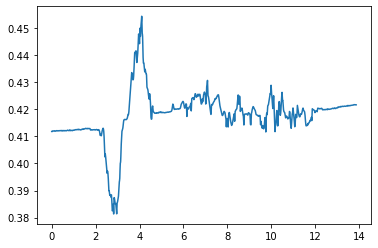

In [15]:
# distance check:
distance_check(MocapQ, MadgwickQ.Q)

In [16]:
# if there are sudden changes:
MocapQ = mocap_correction(MocapQ)
distance_check(MocapQ, MadgwickQ.Q)

#the correction looks okay

In [17]:
solution = transform(MocapQ, MadgwickQ.Q, axis="MAD", n=100)  
                    #mibe, <- mit, axis = melyiknek forgattuk a tengelyeit,n = hánynak az átlagát vettük
print (solution)
time=np.zeros(len(MocapQ))

Moctest=np.zeros((len(MocapQ),4))
distance=np.zeros(len(MocapQ))

for i in range(d.data.shape[0]): # quaterniok átfordítása
    time[i] = i*0.004
    
    q10=turn(solution, MadgwickQ.Q[i], axis ="MAD") # fogató quat, mit forgat, axis = melyiknek forgattuk a tengelyeit
    Moctest[i]=q10
    
    q1 = Quaternion(q10[0],q10[1],q10[2],q10[3])
    q2 = Quaternion(MocapQ[i][0],MocapQ[i][1],MocapQ[i][2],MocapQ[i][3])
    
    distance[i]=Quaternion.sym_distance(q1,q2)

[ 0.91629913  0.00404083  0.40018782 -0.01513226]


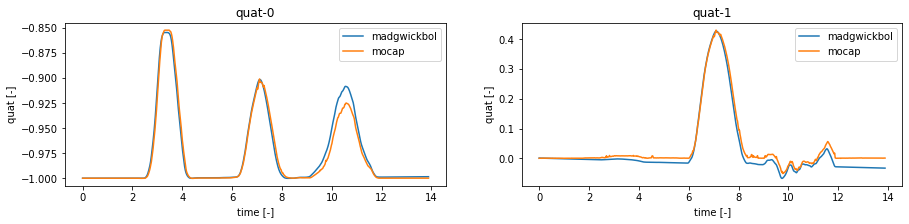

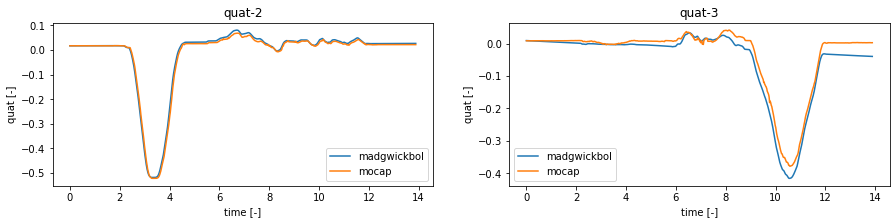

In [18]:
#plottolás
plt.figure(1, figsize=(15, 3))

plt.subplot(121)
plt.title("quat-0")
plt.plot(time,Moctest[:,0],label='madgwickbol')
plt.plot(time,MocapQ[:,0],label='mocap')
plt.xlabel('time [-]')
plt.ylabel('quat [-]')
plt.legend()

plt.subplot(122)
plt.title("quat-1")
plt.plot(time,Moctest[:,1],label='madgwickbol')
plt.plot(time,MocapQ[:,1],label='mocap')
plt.xlabel('time [-]')
plt.ylabel('quat [-]')
plt.legend()

plt.figure(2, figsize=(15, 3))
plt.subplot(121)
plt.title("quat-2")
plt.plot(time,Moctest[:,2],label='madgwickbol')
plt.plot(time,MocapQ[:,2],label='mocap')
plt.xlabel('time [-]')
plt.ylabel('quat [-]')
plt.legend()

plt.subplot(122)
plt.title("quat-3")
plt.plot(time,Moctest[:,3],label='madgwickbol')
plt.plot(time,MocapQ[:,3],label='mocap')
plt.xlabel('time [-]')
plt.ylabel('quat [-]')
plt.legend()

plt.figure(3, figsize=(15, 3))
plt.subplot(111)
plt.title("distance")
plt.plot(time,distance)
plt.xlabel('time [-]')
plt.ylabel('distance [-]')
plt.show()

# EULER Representation

In [19]:
import numpy as np #az importált q-->e fv

def quaternion_to_euler_angle_vectorized1(w, x, y, z):
    ysqr = y * y

    t0 = +2.0 * (w * x + y * z)
    t1 = +1.0 - 2.0 * (x * x + ysqr)
    X = np.degrees(np.arctan2(t0, t1))

    t2 = +2.0 * (w * y - z * x)
    t2 = np.where(t2>+1.0,+1.0,t2)
    #t2 = +1.0 if t2 > +1.0 else t2

    t2 = np.where(t2<-1.0, -1.0, t2)
    #t2 = -1.0 if t2 < -1.0 else t2
    Y = np.degrees(np.arcsin(t2))

    t3 = +2.0 * (w * z + x * y)
    t4 = +1.0 - 2.0 * (ysqr + z * z)
    Z = np.degrees(np.arctan2(t3, t4))

    return X, Y, Z 



In [20]:
#euler szögekkel való reprezentálás
MocapEuler = np.zeros((MocapQ.shape[0], 3))
MadEuler = np.zeros((MocapQ.shape[0], 3))
for i in range(MocapQ.shape[0]):
    MocapEuler[i,:] = quaternion_to_euler_angle_vectorized1(MocapQ[i,0], MocapQ[i,1], MocapQ[i,2], MocapQ[i,3])
    MadEuler[i,:] = quaternion_to_euler_angle_vectorized1(Moctest[i,0], Moctest[i,1], Moctest[i,2], Moctest[i,3])
    
distance_alfa=np.zeros((MocapQ.shape[0]))
distance_beta=np.zeros((MocapQ.shape[0]))
distance_gamma=np.zeros((MocapQ.shape[0]))
for i in range(MocapQ.shape[0]):
    distance_alfa[i]= MocapEuler[i,0] - MadEuler[i,0]
    if (distance_alfa[i] > 180):
        distance_alfa[i]-=360
    if (distance_alfa[i] < -180):
        distance_alfa[i]+=360
    distance_beta[i]= MocapEuler[i,1] - MadEuler[i,1]
    if (distance_beta[i] > 180):
        distance_beta[i]-=360
    if (distance_beta[i] < -180):
        distance_beta[i]+=360
    distance_gamma[i]= MocapEuler[i,2] - MadEuler[i,2]
    if (distance_gamma[i] > 180):
        distance_gamma[i]-=360
    if (distance_gamma[i] < -180):
        distance_gamma[i]+=360
    


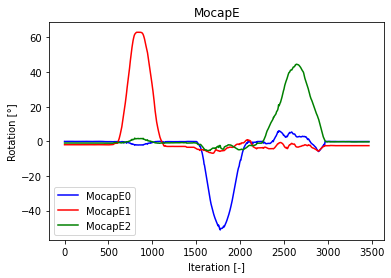

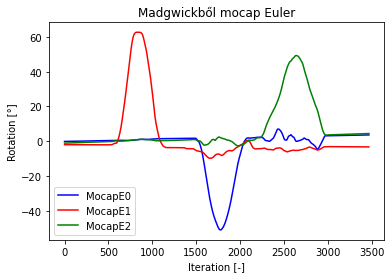

In [21]:
plt.title("MocapE")
plt.plot(MocapE[:,0], color='blue', label='MocapE0')
plt.plot(MocapE[:,1], color='red', label='MocapE1')
plt.plot(MocapE[:,2], color='green', label='MocapE2')
plt.xlabel('Iteration [-]')
plt.ylabel('Rotation [°]')
plt.legend()
plt.show()
'''
plt.title("MocapEuler")
plt.plot(MocapEuler[:,0], color='blue', label='MocapE0')
plt.plot(MocapEuler[:,1], color='red', label='MocapE1')
plt.plot(MocapEuler[:,2], color='green', label='MocapE2')
plt.xlabel('Iteration [-]')
plt.ylabel('Rotation [°]')
plt.legend()
plt.show()
'''
plt.title("Madgwickből mocap Euler")
plt.plot(MadEuler[:,0], color='blue', label='MocapE0')
plt.plot(MadEuler[:,1], color='red', label='MocapE1')
plt.plot(MadEuler[:,2], color='green', label='MocapE2')
plt.xlabel('Iteration [-]')
plt.ylabel('Rotation [°]')
plt.legend()
plt.show()

In [22]:
plt.title("MocapE")
plt.plot(MocapE[:,1], color='red', label='MocapE1')
plt.plot(MadEuler[:,1], color='blue', label='MocapE1')
plt.xlabel('Iteration [-]')
plt.ylabel('Rotation [°]')
plt.legend()
plt.show()

In [23]:
plt.title("euler_mistake")
plt.plot(distance_alfa, color='red', label='alfa')
plt.plot(distance_beta, color='blue', label='beta')
plt.plot(distance_gamma, color='green', label='gamma')
plt.xlabel('Iteration [-]')
plt.ylabel( 'difference[°]')
plt.legend()
plt.show()

avg_gamma = np.average(np.abs(distance_gamma))
avg_beta = np.average(np.abs(distance_beta))
avg_alfa = np.average(np.abs(distance_alfa))
print('average differences')
print('alfa:',avg_alfa,'  beta:',avg_beta, '  gamma:', avg_gamma)

average differences
alfa: 1.774130040836382   beta: 0.8997429689101041   gamma: 2.2264483991942483
